# Programmentwurf Data Science
#### Ilvy Schulz und Pia Skuthan

In [1]:
# Alle Importe der Datei - bitte zum Anfang einmal ausführen
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd 
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF

## 1. Data Understanding - Test

Zuerst werden die Daten aus der Datei eingelesen und anschließend wird die Form überprüft.
So kann sicher gestellt werden, dass die Daten richtig eingelesen werden und, wie vorgegeben, die Form (128, 128 191) besitzt.

In [2]:
ims_cube = scipy.io.loadmat("ims_cube.mat")["ims_cube"]
ims_cube.shape

(128, 128, 191)

Um die räumliche Verteilung einzelner Features des Datensatzes zu untersuchen, werden exemplarisch acht Kanäle aus dem Spektralbereich ausgewählt.
Da die Daten 191 spektrale Kanäle (0–190) umfassen, werden die Features in 25er-Schritten gewählt, um eine gleichmäßige Verteilung über das gesamte Spektrum zu erhalten und verschiedene Bereiche der Daten zu betrachten. Um die räumliche Verteilung möglichst erkennbar zu machen, wird hier die Color Map "Jet" genutzt, die auch kleine Änderungen deutlich sichtbar macht.

Hier fällt auch auf, dass einige Features (wie 140 oder 190) nicht existieren bzw. der plot nur einfarbig ist und keine räumliche Verteilung aufweist. Diese Features wurden absichtlich nicht geplottet, da man keinerlei weitere Informationen aus diesen Verteilungen ziehen kann.

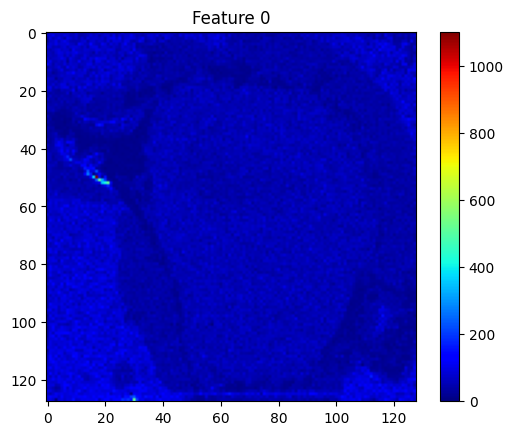

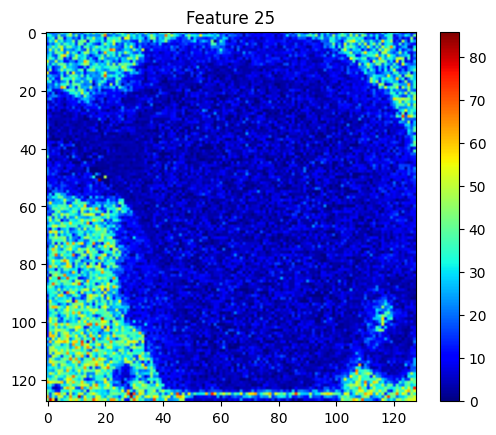

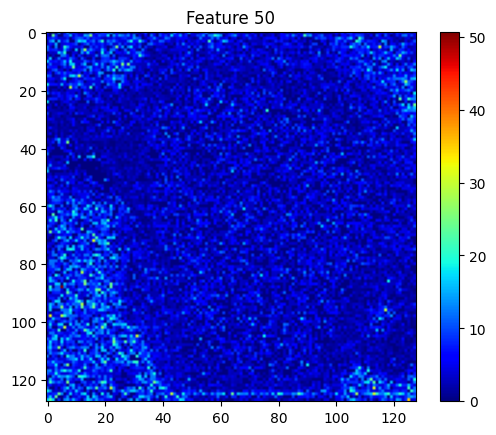

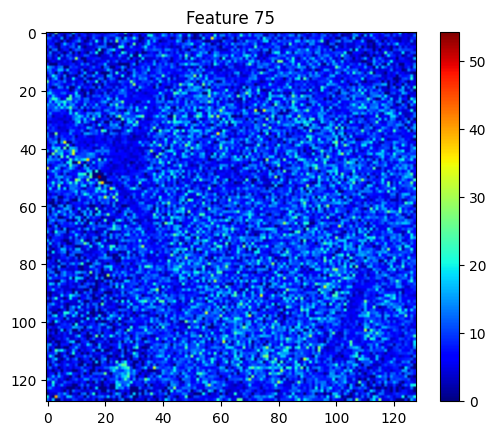

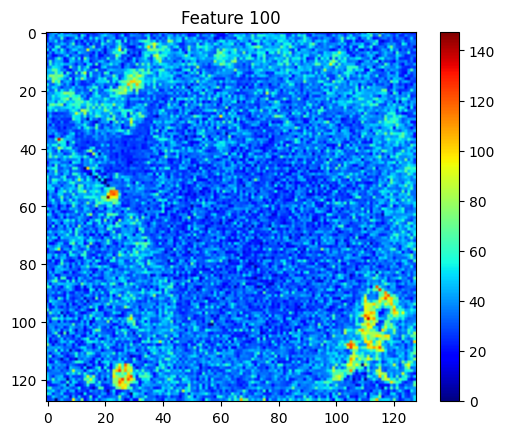

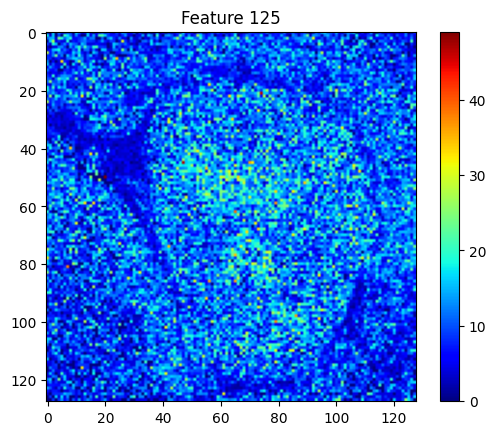

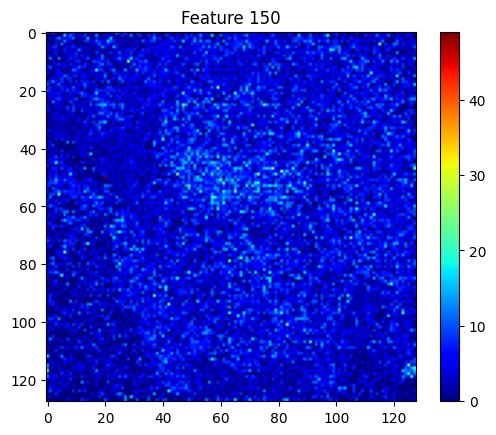

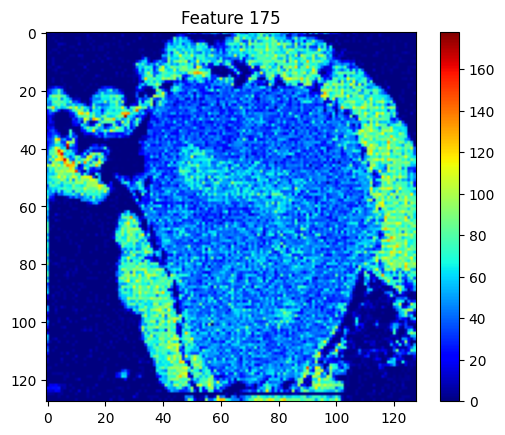

In [3]:
for i in range(0,190,25):
    plt.imshow(ims_cube[:, :, i], cmap='jet')
    plt.title(f"Feature {i}")
    plt.colorbar()
    plt.show()

Nun werden einmal einige Spektren in einem Diagramm aufgezeigt. Es werden hier schon einige Überlappende Feautures deutlich, um die Intensität der Features im gesamten noch einmal zu sehen, wurde anschließend einmal ein mittleres Spektrum der Daten visualisiert.

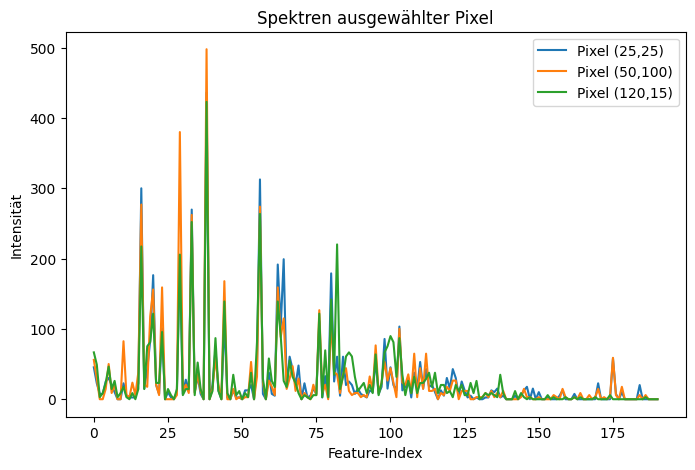

In [4]:
pixel_coords = [(25, 25), (50, 100), (120, 15)]

plt.figure(figsize=(8, 5))

for (x, y) in pixel_coords:
    spectrum = ims_cube[x, y, :]
    plt.plot(range(ims_cube.shape[2]), spectrum, label=f'Pixel ({x},{y})')

plt.xlabel('Feature-Index')
plt.ylabel('Intensität')
plt.title('Spektren ausgewählter Pixel')
plt.legend()
plt.show()

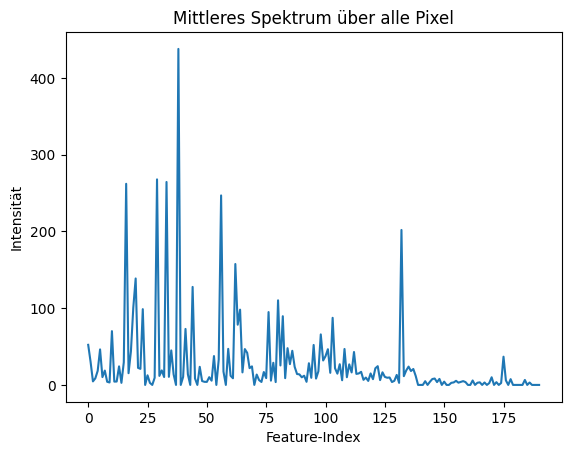

In [5]:
mean_spectrum = ims_cube.mean(axis=(0, 1))
plt.plot(mean_spectrum)
plt.title('Mittleres Spektrum über alle Pixel')
plt.xlabel('Feature-Index')
plt.ylabel('Intensität')
plt.show()

In dem Graphen wird nun deutlich, dass die durschnittliche Intensität bei einzelnen Features deutlich höher ist, also bei anderen. Um die genauen Features herauszufiltern, die deutlich herausstechen, wurde im nachfolgenden mithilfe von Z-Score eine anomaly detection durchgeführt.
Zum anderen fällt hier auch auf, dass die Intensität der ersten 100 Features deutlich höher ist als die der letzten 90.

In [6]:
z_scores = np.abs(stats.zscore(mean_spectrum))
threshold = 2.5
highest_intensity = np.where(z_scores > threshold)[0]

print("Features mit auffällig hoher durchschnittlicher Intensität:\n", highest_intensity)


Features mit auffällig hoher durchschnittlicher Intensität:
 [ 16  29  33  38  56 132]


## 2. Data Preparation

### Clustering

Wie in der ersten Aufgabe schon angemerkt, gibt es einige Features mit sehr geringer Varianz. Diese sind im weiteren Verlauf nicht hilfreich, sondern eher Störvariablen. 

Um diese Features rauszufiltern wird im folgenden der Datensatz zuerst umgeformt, anschließend wird die Varianz der unterschiedlichen Features berechnet und die "aktiven" Features gefiltert.

In [7]:
variances = ims_cube.reshape(-1, ims_cube.shape[2]).var(axis=0)
active_channels = np.where(variances > 1e-6)[0]
ims_cube_reduced = ims_cube[:, :, active_channels]
print(f"Neue Form nach Filterung: {ims_cube_reduced.shape}")

Neue Form nach Filterung: (128, 128, 157)


Nun das nur noch relevante Features im Datensatz für das Clustering vorhanden sind, muss die Form noch an das Clustering Verfahren angepasst werden.
Aus drei Dimensionen, muss eine zwei Dimensionale Liste werden, damit das Clustering jeden Pixel als eigenständigen Datenpunkt betrachten kann.

Deshalb wird der Datensatz in eine 2D-Matrix umgeformt:

- Jede Zeile steht für einen einzelnen Pixel (insgesamt 128×128 = 16384 Pixel)
- Jede Spalte steht für ein Merkmal, also einen Spektralkanal

Anschließend werden die Features mit Z-Score normalisiert. Dabei wird jedes Feature so angepasst, dass er einen Mittelwert von 0 und eine Standardabweichung von 1 besitzt. Das verhindert, dass Kanäle mit höheren Intensitäten das Clustering dominieren und sorgt dafür, dass alle Features vergleichbar sind.

In [8]:
pixel_matrix = ims_cube_reduced.reshape(-1, ims_cube_reduced.shape[2])
scaler = StandardScaler()
pixel_matrix_norm = scaler.fit_transform(pixel_matrix)

### PCA & NMF

In der Aufgabe 4 werden wir einmal eine Principal Component Analysis (PCA) und dann noch die Non-negative Matrix Factorization (NMF) Methode verwenden. 

Für beides müssen wir den Datensatz aufbreiten. Da wir aus dem 3D Datensatz mit dem "reshape" einen 2D Datensatz generieren müssen, da PCA und NMF mit Tabellen arbeitet. Hätte man die Daten nicht in "D umgewandelt, könnte der Algorithmus später nicht "durch die Pixel gehen" und die Gemeinsamkeiten und Spektren erkennen, da nur im 2D die Rechenoperationen möglich sind.

Die Zeilen sind die Pixel und die Spalten sind die Spektralkanäle:

In [ ]:
X = ims_cube.reshape(-1, ims_cube.shape[2])
print("Form der Datenmatrix:", X.shape)

Jetzt müssen die Daten für das PCA standardisiert werden, damit alle Features gleich gewichtet werden.

Dabei wird der Mittelwert jeder Spalte auf 0 gesetzt und die Varianz auf 1 skaliert.

Das sorgt dafür, dass PCA die Varianz um den Ursprung (0) sucht und nicht um einen beliebigen anderen Punkt im Raum.
Die Varianz auf 1 zu setzen ist wichtig, weil dadurch jede Spalte dieselbe Skala erhält und die Werte zwischen den Kanälen vergleichbar werden. So werden alle Spektralkanäle gleich behandelt, und PCA kann echte Muster und Zusammenhänge in den Daten erkennen und dies unabhängig von unterschiedlichen Messbereichen.

N steht für die ANzahl der Pixel und P für die Anzahl der Feautures

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
N, p = X_std.shape
print("Die Daten für PCA sind vorbereitet.")

Für die NMF-Methode müssen alle Daten positiv sein, da NMF die Daten als additive Kombination positiver Komponenten beschreibt. Negative Werte würden hier keinen Sinn ergeben, da man keine „negativen Anteile“ von Spektren haben kann.
Damit alle Werte positiv sind, wird der Datensatz so verschoben, dass der kleinste Wert 0 ist:

In [ ]:
X_nmf = X - np.min(X)
print("Die Daten für NMF sind vorbereitet.")

## 3. Modeling & Evaluation: Clustering

Um Clustering auf diesem Datensatz anzuwenden, bietet sich am meisten K-Means-Clustering an.
Es ist für einen größeren Datensatz, wie diesen rechnerisch effizient und die Daten können auf Basis der Ähnlichkeiten der Features in K Cluster aufgeteilt werden. Da unterschiedliche Geweberegionen beschrieben werden, werden auch klare Clusterzentren geliefert.

### K-Means-Clustering

K-Means funktioniert indem zuerst zufällige Clusterzentren definiert werden und jedem Datenpunkt das nächstliegende Zentrum zugeordnet wird.
Anschließend werden die Clusterzentren als Mittelwert der zugehörigen Datenpunkte neu berechnet. Diese Schritte werden dann wiederholt, bis sich die Zuordnungen nicht mehr ändern.

Zuerst wird die Clusterzentren variiert, um die mathematisch beste Aufteilung herauszufinden. Der Silhouette Score von sklearn, gibt dabei an wie gut getrennt Cluster sind. Je höher der Score desto besser.

k=2: Silhouette=0.253
k=3: Silhouette=0.213
k=4: Silhouette=0.132
k=5: Silhouette=0.128
Optimale Clusteranzahl: 2


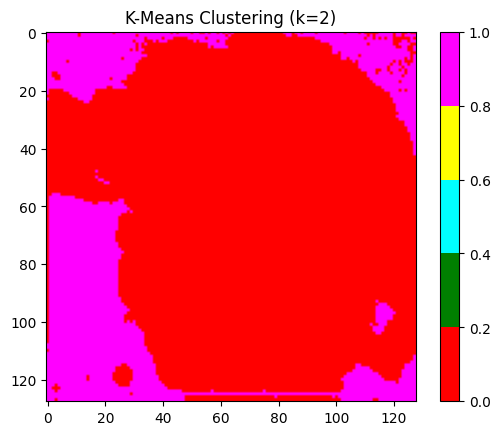

In [9]:
range_k = range(2, 6)
sil_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixel_matrix_norm)
    sil = silhouette_score(pixel_matrix_norm, labels)
    sil_scores.append(sil)
    print(f"k={k}: Silhouette={sil:.3f}")

best_k = range_k[np.argmax(sil_scores)]
print(f"Optimale Clusteranzahl: {best_k}")

# Clustering mit optimalem k wiederholen
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(pixel_matrix_norm)

# 2D-Rekonstruktion
label_map = labels.reshape(128, 128)
farben = ['red', 'green', 'cyan', 'yellow', 'magenta']
plt.imshow(label_map, cmap=plt.matplotlib.colors.ListedColormap(farben))
plt.title(f'K-Means Clustering (k={best_k})')
plt.colorbar()
plt.show()

Anhand des Silhouette Score ist k=2, mathematisch die bestmögliche Aufteilung.

Es besteht jedoch aus der Aufgabenstellung das Wissen, dass es biologisch in k=5 aufgeteilt werden sollte. Um dies nochmal anzuschauen, wird das Clustering nun nochmals mit k=5 durchgeführt, auch wenn der Silhouette Score mit 0.128 deutlich geringer ist als 0.253 von k=2

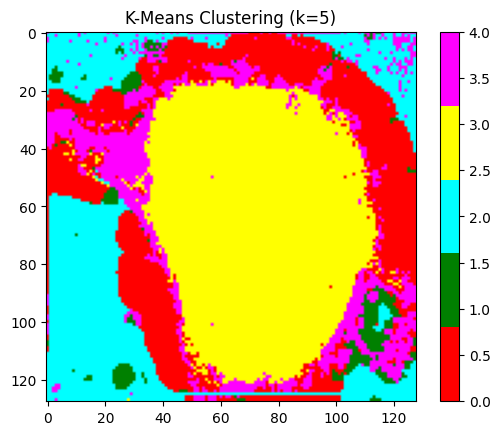

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(pixel_matrix_norm)
label_map = labels.reshape(128, 128)
farben = ['red', 'green', 'cyan', 'yellow', 'magenta']
plt.imshow(label_map, cmap=plt.matplotlib.colors.ListedColormap(farben))
plt.title('K-Means Clustering (k=5)')
plt.colorbar()
plt.show()

Beim Clustering mit K-Means wird zuerst erkannt, dass der Silhouette-Score für k=2 am höchsten ist. Das bedeutet, dass die Daten sich mathematisch am besten in zwei große Bereiche aufteilen lässt, die sich deutlich voneinander unterscheiden. Auf der Visualisierung erkennt man dann zwei verschiedene Regionen – zum Beispiel könnte das grob "Tumor" und "anderes Gewebe" sein.

Die Aufgabe gibt aber vor, dass in fünf Klassen aufgeteilt wird, weil biologisch fünf verschiedene Gewebetypen vorkommen (z.B. necrotic tumor, viable tumor, Interface, gelatin, glass). Deshalb wird das Clustering nochmal mit k=5 gemacht. Jetzt sieht man fünf unterschiedlich gefärbte Bereiche, die mit den echten Gewebsklassen vergleichbar sind. Der Silhouette-Score ist bei k=5 aber niedriger. Die Gruppen sind nicht mehr so klar getrennt wie bei zwei Clustern. Das liegt daran, dass sich die Daten der Gewebearten stark überschneiden.

Trotzdem hilft das Clustering weiter, weil die fünf Regionen anzeigen, wo sich wahrscheinlich die verschiedenen Gewebetypen befinden. Auch wenn die mathematische Bewertung nicht perfekt ist, bringt es einen Mehrwert für Wissenschaftler*innen. Sie können gezielt bestimmte Regionen im Bild auswählen und genauer untersuchen, ohne dass sie vorher aufwendig markiert werden müssen.

## Modeling & Evaluation: PCA & NMF

### Principal Component Analysis (PCA)

Ziel ist es, die charakteristische Spektren (Hauptkomponenten) zu identifizieren und deren räumliche Verteilung sichtbar zu machen.

Wie im Unterricht besprochen, wird die PCA mithilfe der SVD (Singulärwertzerlegung) berechnet.
Die Datenmatrix X wird dabei in drei Matrizen zerlegt:
X = U * S * V^T

X ist die Datenmatrix, also die standardisierten Spektren aller Pixel.
𝑈 * S (scores) gibt an, wie stark jede der gefundenen Komponenten (Hauptkomponenten) bei jedem Pixel vertreten ist, also die räumliche Verteilung der Komponenten.
V = Spalten von V sind die Hauptkomponenten (charakteristische Spektren)
V^T ist die Transportierte Matrix von V, sodass die Multiplikation mathematisch korrekt ist.

Eigenvalues (Eigenwerte) zeigen, wie viel Varianz jede Hauptkomponente hat.

In [14]:
U, s, Vt = svd(X_std, full_matrices=False)
V = Vt.T
eigenvalues = (s**2) / (N - 1) 
scores = np.dot(U, np.diag(s))



Jetzt erstellen wir ein Scree-Plot.
Dieses Diagramm zeigt, wie viel Varianz in den Daten durch jede Hauptkomponente erklärt wird.
Das ist wichtig, da die PCA genau die Richtungen im Datenraum sucht, in denen die Varianz maximal ist.

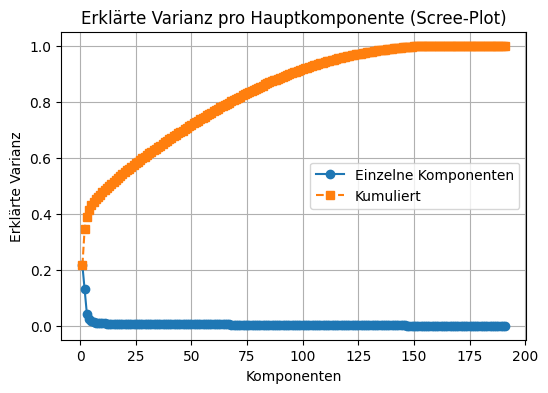

In [15]:

explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cum_var = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-', label="Einzelne Komponenten")
plt.plot(np.arange(1, len(cum_var)+1), cum_var, 's--', label="Kumuliert")
plt.xlabel("Komponenten")
plt.ylabel("Erklärte Varianz")
plt.title("Erklärte Varianz pro Hauptkomponente (Scree-Plot)")
plt.legend()
plt.grid(True)
plt.show()


In der blauen Kurve sehen wir die erklärte Varianz jeder einzelnen Komponente.
Die ersten Komponenten haben dabei sehr hohe Varianzanteile, danach fällt die Kurve schnell ab und verläuft nahezu flach.
Das bedeutet, dass die ersten Hauptkomponenten bereits den größten Teil der Information im Datensatz enthalten.

Die orangefarbene Kurve zeigt die kumulierte erklärte Varianz.
Sie steigt anfangs stark an und nähert sich dann einem Wert nahe 1 (bzw. 100 %).
Daraus erkennen wir, dass wir nur wenige Hauptkomponenten benötigen, um fast die gesamte Varianz zu erfassen.
Nach etwa drei bis fünf Komponenten bringt jede zusätzliche Komponente nur noch einen sehr geringen Informationsgewinn.

Im Diagramm sehen wir, dass die ersten Hauptkomponenten den größten Sprung in der erklärten Varianz zeigen.
Um das zu überprüfen, haben wir die exakten Werte der ersten zehn Komponenten berechnet.
Die ersten fünf Komponenten erklären zusammen etwa 43 % der Gesamtvarianz.
Ab der sechsten Komponente steigt die kumulierte Varianz nur noch sehr langsam an und von der sechsten bis zur zehnten Komponente beträgt der zusätzliche Anstieg lediglich 4,67 %.
Aus diesem Grund haben wir uns entschieden, in der weiteren Analyse nur mit den ersten fünf Hauptkomponenten weiterzuarbeiten.

In [16]:
for i in range(10):
    print(f"PC{i+1}: {explained_variance_ratio[i]*100:.2f}% (kumuliert: {cum_var[i]*100:.2f}%)")


PC1: 21.52% (kumuliert: 21.52%)
PC2: 13.09% (kumuliert: 34.60%)
PC3: 4.28% (kumuliert: 38.88%)
PC4: 2.30% (kumuliert: 41.19%)
PC5: 1.82% (kumuliert: 43.01%)
PC6: 1.21% (kumuliert: 44.22%)
PC7: 0.93% (kumuliert: 45.15%)
PC8: 0.89% (kumuliert: 46.03%)
PC9: 0.83% (kumuliert: 46.86%)
PC10: 0.82% (kumuliert: 47.68%)


Im nächsten Schritt betrachten wir die charakteristischen Spektren der Hauptkomponenten.
Jede Spalte der Matrix V beschreibt ein typisches Muster im Spektrum, also eine Kombination von Spektralkanälen, die gemeinsam stark variieren.
Wir visualisieren die ersten fünf Hauptkomponenten, um zu sehen, welche Wellenlängenbereiche besonders relevant sind.
Starke positive oder negative Ausschläge zeigen, welche Spektralkanäle für die jeweilige Komponente besonders prägend sind.
Diese Spektren bilden die Grundlage für die anschließende räumliche Analyse der Daten.

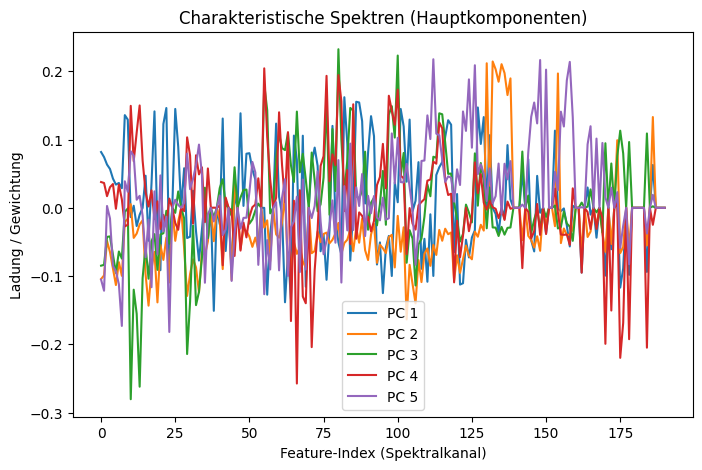

In [17]:
n_components = 5 
plt.figure(figsize=(8,5))
for i in range(n_components):
    plt.plot(V[:, i], label=f"PC {i+1}")
plt.xlabel("Feature-Index (Spektralkanal)")
plt.ylabel("Ladung / Gewichtung")
plt.title("Charakteristische Spektren (Hauptkomponenten)")
plt.legend()
plt.show()

Im nächsten Schritt betrachten wir die räumliche Verteilung der Hauptkomponenten.
Jede Spalte in der Matrix scores beschreibt, wie stark die jeweilige Hauptkomponente in jedem Pixel vertreten ist.
Durch das Rückformen in die ursprüngliche Bildgröße (128×128 Pixel) entstehen sogenannte Score Maps.
Diese zeigen, in welchen Bereichen des Gewebes bestimmte spektrale Muster dominieren.
Dadurch können unterschiedliche Gewebestrukturen oder Regionen visuell voneinander abgegrenzt werden.

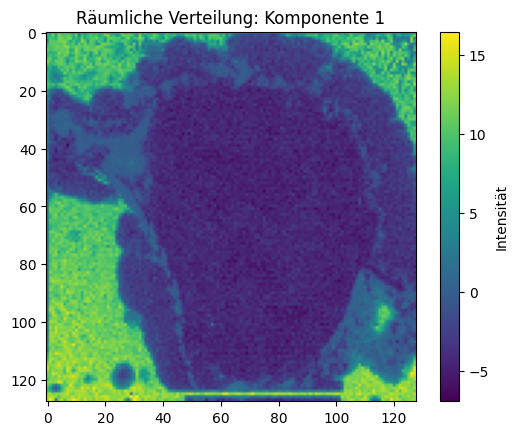

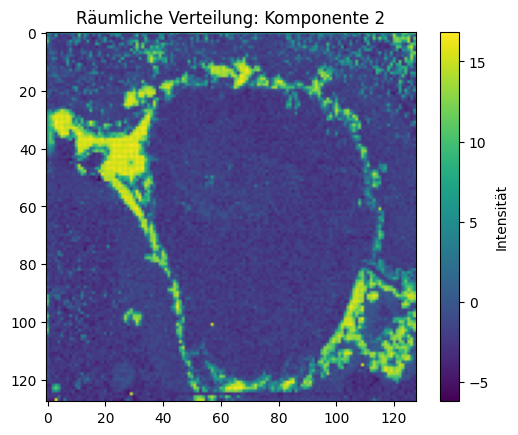

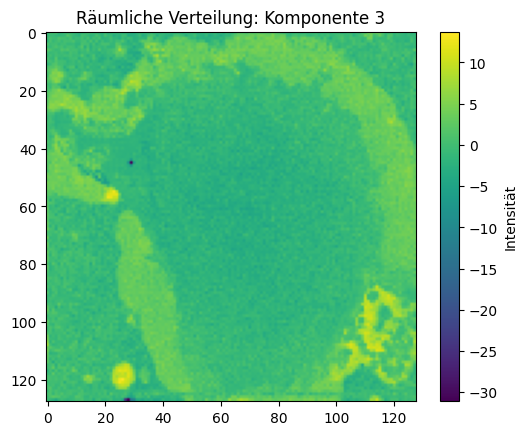

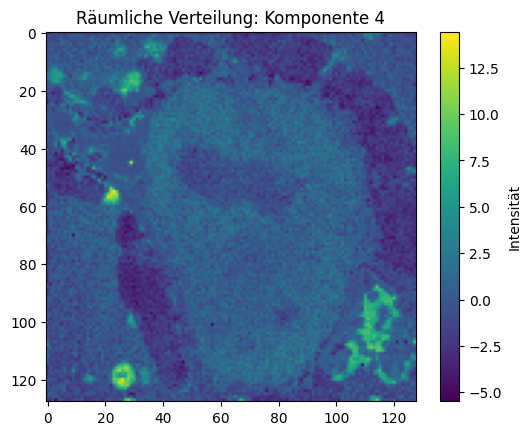

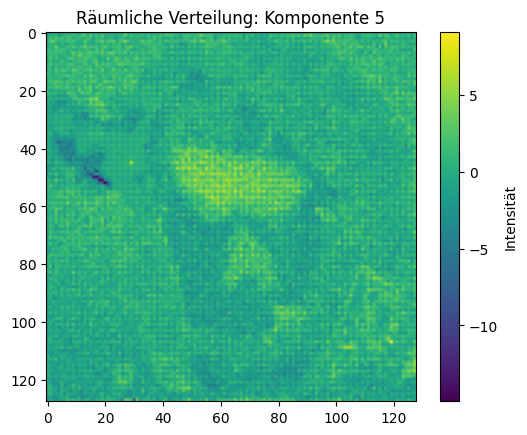

In [18]:
for i in range(n_components):
    plt.imshow(scores[:, i].reshape(128,128), cmap="viridis")
    plt.title(f"Räumliche Verteilung: Komponente {i+1}")
    plt.colorbar(label="Intensität")
    plt.show()

Die räumlichen Verteilungen (Score-Maps) zeigen, in welchen Bereichen des Gewebes die jeweiligen Hauptkomponenten besonders stark ausgeprägt sind.
Komponente 1 trennt das eigentliche Gewebe deutlich vom Hintergrund. Hier sind die hellen Bereiche klar auf das Gewebe konzentriert, während dunkle Regionen den Hintergrund markieren – sie spiegelt also den grundlegenden Kontrast im Datensatz wider.
Komponente 2 hebt vor allem Randzonen und Übergangsbereiche hervor. Diese Komponente könnte beispielsweise einem Tumorrand oder Grenzregionen zwischen unterschiedlichen Gewebearten entsprechen.
Komponente 3 beschreibt gleichmäßig verteilte Intensitätsunterschiede über das gesamte Bild. Sie steht eher für allgemeine Helligkeitsschwankungen im Gewebe, nicht für spezifische Strukturen.
Komponente 4 zeigt feinere, lokale Strukturen innerhalb des Gewebes. Hier treten punktuelle oder kleinere Muster auf, die möglicherweise auf unterschiedliche Zelltypen oder Dichteunterschiede hinweisen.
Komponente 5 hingegen enthält kaum noch erkennbare Strukturen und zeigt hauptsächlich zufällige Schwankungen – also Rauschen.

Insgesamt wird deutlich, dass die ersten beiden Komponenten die größten und klarsten Unterschiede im Gewebe darstellen, während Komponente 3 und 4 zusätzliche, feinere Details enthalten. Ab der fünften Komponente nimmt der Informationsgehalt stark ab, weshalb insbesondere die ersten vier Hauptkomponenten die wesentlichen räumlichen Muster im Datensatz beschreiben.

### Non-negative Matrix Factorization (NMF)

Das NMF zerlegt die Datenmatrix in zwei kleinere Matrizen, jedoch nur mit positiven Werten.
Daraus ergibt sich: 𝑋 ≈ 𝑊 * 𝐻
Die ursprüngliche Datenmatrix 𝑋 wird also in W und H aufgeteilt, nur näherungsweise, da negative Werte nicht berücksichtigt werden.
Die Matrix W beschreibt, wie stark jede Komponente bei jedem Pixel vertreten ist, also die räumliche Verteilung.
Die Matrix H enthält die charakteristischen Spektren, die die typischen Muster oder Basisprofile der Daten darstellen.

Wir wählen fünf Komponenten, da wir uns an den Ergebnissen der PCA orientieren.
Im Scree-Plot wurde deutlich, dass die erklärte Varianz nach der fünften Komponente nur noch minimal zunimmt.
Das bedeutet, dass danach kaum neue Informationen hinzukommen, sondern hauptsächlich Rauschen.
Auch bei der NMF führt eine höhere Komponentenzahl zu unruhigeren Karten und schwer interpretierbaren Ergebnissen.
Fünf Komponenten sind daher ein guter Kompromiss, ausreichend, um die wichtigen Strukturen im Gewebe zu erfassen, ohne Überanpassung zu riskieren.

In [19]:
n_components = 5

Jetzt erstellen wir das NMF-Modell und dann führen wir die Zerlegung aus,

init='nndsvda' ist die Startmethode und sorgt für eine gute und stabile Anfangsschätzung, da sie auf der Singulärwertzerlegung (SVD) basiert. Dadurch startet der Algorithmus nicht zufällig, sondern bereits mit einer sinnvollen Annäherung an die tatsächlichen Strukturen.

random_state=42 legt den Startwert für den Zufallsgenerator fest.
Er sorgt dafür, dass bei jedem Lauf die gleichen Ergebnisse entstehen, also die Analyse reproduzierbar ist.

max_iter=500 bedeutet, dass der Algorithmus höchstens 500 Iterationen durchläuft, um eine stabile Lösung zu finden

In [20]:
nmf_model = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=500)

W = nmf_model.fit_transform(X_nmf)
H = nmf_model.components_

print("Form von W:", W.shape)
print("Form von H:", H.shape)

Form von W: (16384, 5)
Form von H: (5, 191)


Räumliche Verteilung der Komponenten (W-Matrix)

Zuerst betrachten wir die räumlichen Verteilungen der Komponenten.
Jede Spalte in W zeigt, wo im Bild die jeweilige Komponente stark vertreten ist.
Durch das Rückformen in die ursprüngliche Bildgröße (128×128) können wir diese als Abbildung darstellen.

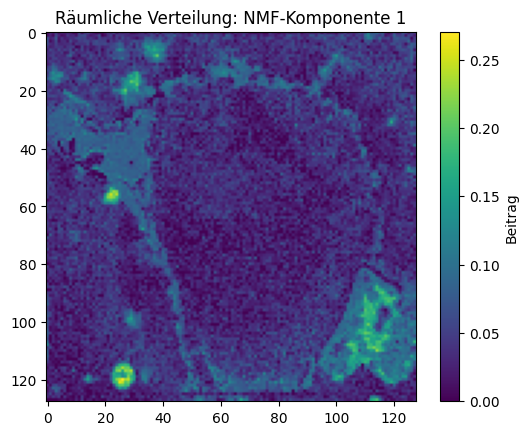

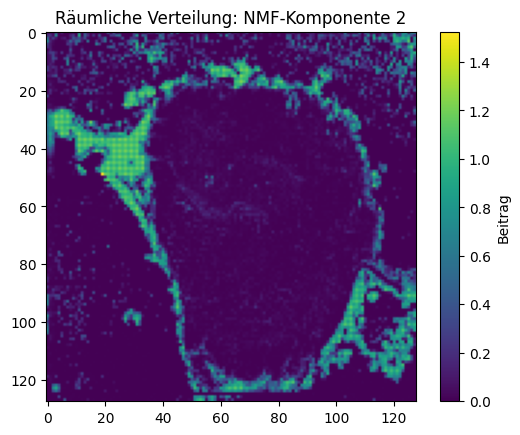

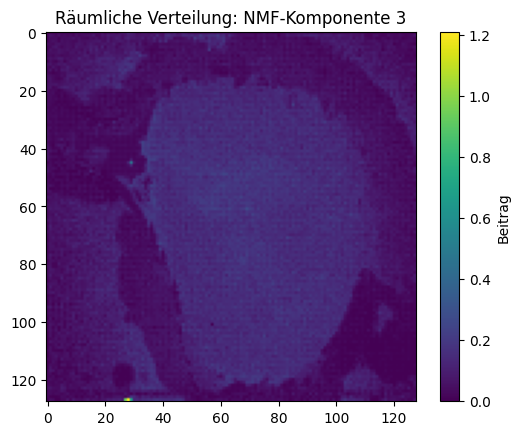

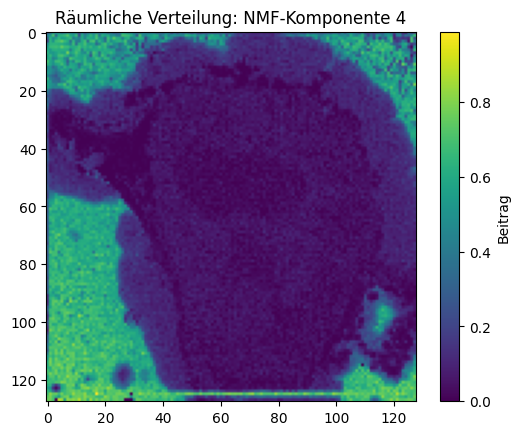

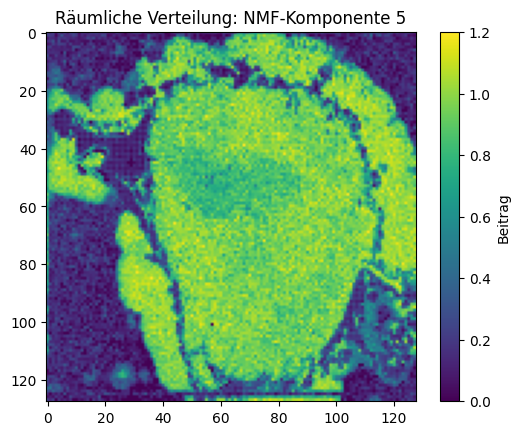

In [21]:
for i in range(n_components):
    plt.imshow(W[:, i].reshape(128,128), cmap="viridis")
    plt.title(f"Räumliche Verteilung: NMF-Komponente {i+1}")
    plt.colorbar(label="Beitrag")
    plt.show()

Die Score-Maps zeigen, in welchen Bereichen des Gewebes die jeweiligen NMF-Komponenten dominieren.
**Komponente 1** betont vor allem das innere Gewebe, während **Komponente 2** im Gegensatz dazu die Randzonen und Übergangsbereiche deutlich hervorhebt, was auf mögliche Tumorränder hinweist.
**Komponente 3** zeigt ein gleichmäßiges, eher flächiges Muster mit geringen Kontrasten, während **Komponente 4** feinere Strukturen innerhalb des Gewebes sichtbar macht.
**Komponente 5** betont zwar erneut das Gewebeinnere, enthält aber bereits erste Anzeichen von Rauschen.

Insgesamt liefern die NMF-Karten ein glatteres und realistisches Ergebnis als die PCA, da nur positive Werte vorkommen und die Komponenten additive, klar interpretierbare Beiträge darstellen.


Charakteristische Spektren (H-Matrix)

Anschließend betrachten wir die zugehörigen Spektren der Komponenten aus der Matrix H.
Jede Zeile in H repräsentiert ein charakteristisches Spektrum, das ein typisches Muster im Gewebe beschreibt.

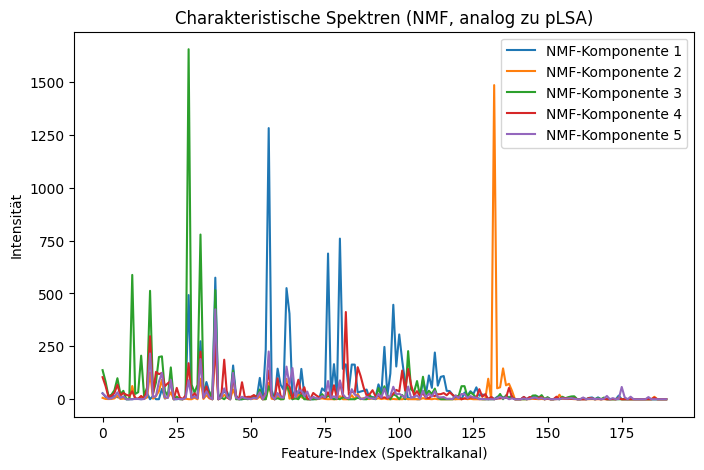

In [22]:
plt.figure(figsize=(8,5))
for i in range(n_components):
    plt.plot(H[i], label=f'NMF-Komponente {i+1}')
plt.xlabel("Feature-Index (Spektralkanal)")
plt.ylabel("Intensität")
plt.title("Charakteristische Spektren (NMF, analog zu pLSA)")
plt.legend()
plt.show()

Die charakteristischen Spektren der H-Matrix zeigen, welche Wellenlängenbereiche für die jeweiligen NMF-Komponenten typisch sind.

Komponente 1 weist mehrere deutliche Peaks im mittleren Bereich auf und beschreibt damit dominante Signale, die auch in den zentralen Geweberegionen sichtbar waren.
Komponente 2 zeigt einen starken Peak im höheren Wellenlängenbereich, was zu den klar abgegrenzten Randstrukturen aus der W-Matrix passt.
Komponente 3 hat mehrere schwächere Ausschläge über das gesamte Spektrum verteilt, was auf gleichmäßigere, weniger spezifische Signale hindeutet.
Komponente 4 besitzt einzelne markante Peaks im mittleren Bereich, die feine spektrale Unterschiede abbilden.
Komponente 5 zeigt ebenfalls einige breitere, aber schwächere Peaks, was mit der etwas verrauschten Struktur dieser Komponente übereinstimmt.

Insgesamt wird deutlich, dass die ersten beiden Komponenten die stärksten und klarsten spektralen Merkmale tragen, während die späteren Komponenten zunehmend weniger Struktur und mehr Rauschanteile enthalten.

### Vor und Nachteile PCA & NMF

#### PCA:

Vorteile:

- Effiziente Dimensionsreduktion, da schon wenige Hauptkomponenten den größten Teil der Varianz der Daten zusammenfassen. Dadurch lassen sich große Datensätze stark vereinfachen, ohne viel Information zu verlieren.

- Klare mathematische Grundlage, da die Berechnung eindeutig ist, denn die Komponenten sind orthogonal (also unabhängig voneinander) sind. Dadurch entstehen keine Überschneidungen zwischen den Hauptkomponenten.

- Schnell und robust, da PCA sich mit der Singulärwertzerlegung sehr effizient berechnen lässt und dies auch bei großen Datensätzen.

- Gute Erkennung globaler Muster, sie zeigt deutlich, wo die größten Unterschiede im gesamten Datensatz liegen. Z.B. zwischen verschiedenen Gewebearten oder Messregionen.

Nachteile:

- Schwer interpretierbar, da PCA sowohl positive als auch negative Werte liefert, was bei spektralen Daten physikalisch oft keinen Sinn ergibt.

- Mathematisch orientiert, da die Hauptkomponenten nur die Varianz maximieren, aber nicht unbedingt biologisch sinnvolle Muster beschreiben.

- Empfindlich gegenüber Ausreißern, da einzelne extreme Werte die Richtung der Hauptkomponenten stark beeinflussen können.

- Keine additive Zerlegung, da sich positive und negative Anteile gegenseitig aufheben können, wodurch reale Strukturen teilweise verloren gehen.

#### NMF:

Vorteile:

- Nur positive Werte, wodurch die Ergebnisse viel leichter interpretierbar sind, da reale Spektren oder Intensitäten keine negativen Werte enthalten.

- Additives Modell, bei dem jedes Spektrum oder Pixel als Mischung mehrerer positiver Komponenten beschrieben wird. Dadurch können reale Prozesse, wie unterschiedliche Gewebeanteile, gut abgebildet werden.

- Bessere Interpretierbarkeit, da die Komponenten klarer bestimmten Zelltypen, Stoffen oder Regionen zugeordnet werden können.

- Natürlichere räumliche Strukturen, da keine negativen Gegensignale auftreten und die resultierenden Karten glatter und realistischer wirken.

Nachteile:

- Geringere erklärte Varianz, da durch die Beschränkung auf positive Werte weniger Gesamtvarianz abgedeckt wird als bei der PCA.

- Nicht eindeutig, da die Ergebnisse von der Startposition abhängen und sich leicht verändern können.

- Langsamer in der Berechnung, da die NMF iterativ arbeitet und mehrere Rechenschritte benötigt, bis sie konvergiert.

- Empfindlich gegenüber Parameterwahl, da Einstellungen wie Startmethode oder Iterationsanzahl die Ergebnisse beeinflussen können.

#### Fazit:

Die PCA ist mathematisch stabil, schnell und gut geeignet, um große Datenmengen zu strukturieren und Hauptunterschiede zu erkennen.
Die NMF dagegen liefert anschaulichere, realitätsnähere Ergebnisse, da sie nur mit positiven Werten arbeitet und additive Zusammenhänge zeigt.
Für biologische Daten, wie in diesem Datensatz, ist NMF besonders geeignet, weil die Komponenten echte, interpretierbare Strukturen darstellen, während PCA hilft, die dominanten Variationen im gesamten Datensatz zu erkennen.